In [24]:
from google.colab import drive
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from matplotlib import pyplot as plt
import random
import torch.optim as optim
import time
import numpy as np
import itertools as it

In [25]:
print(f"CUDA is available? {torch.cuda.is_available()}")
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

CUDA is available? True
cuda


In [26]:
drive.mount("/content/drive",True)
root_dir = "/content/drive/My Drive/SB3/"

Mounted at /content/drive


In [27]:
train_transform = T.Compose([
    T.Resize(320),
    T.ToTensor()
])

test_transform = T.Compose([
    T.Resize(320),
    T.ToTensor()
])

In [28]:
train_dataset = ImageFolder(os.path.join(root_dir, "train"), transform=train_transform)
test_dataset = ImageFolder(os.path.join(root_dir, "test"), transform=test_transform)
num_classes = len(train_dataset.classes)
print(num_classes)

8


In [29]:
print(len(train_dataset))
print(len(test_dataset))

1109
471


In [30]:
x = train_dataset[0][0]
print(x.max())
print(x.min())

tensor(0.9961)
tensor(0.)


In [31]:
class_counts = [train_dataset.targets.count(i) for i in range(num_classes)]
print(class_counts)

[500, 28, 38, 116, 17, 19, 339, 52]


In [32]:
num_train = len(train_dataset)
idx = list(range(num_train))
val_frac = 0.2
idx_iter = iter(idx)
class_idx = [list(it.islice(idx_iter, x)) for x in class_counts]
class_idx = [random.sample(x,len(x)) for x in class_idx]
train_idx = [x[:-int(len(x)*val_frac)] for x in class_idx]
train_idx = list(it.chain.from_iterable(train_idx))
val_idx = [x[-int(len(x)*val_frac):] for x in class_idx]
val_idx = list(it.chain.from_iterable(val_idx))
val_dataset = Subset(train_dataset,val_idx)
train_dataset = Subset(train_dataset, train_idx)

In [33]:
print(len(train_dataset))
print(len(val_dataset))

891
218


In [34]:
train_counts = [x-int(x*val_frac) for x in class_counts]
max_count = max(train_counts)
#weights = len(train_dataset) / torch.Tensor(train_counts)
#weights = max_count / torch.Tensor(train_counts)
weights = 1 / torch.Tensor(train_counts)
weights = weights.to(dev)
print(weights)

tensor([0.0025, 0.0435, 0.0323, 0.0108, 0.0714, 0.0625, 0.0037, 0.0238],
       device='cuda:0')


In [35]:
val_counts = [int(x*val_frac) for x in class_counts]
print(val_counts)

[100, 5, 7, 23, 3, 3, 67, 10]


In [36]:
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset,   batch_size=4, num_workers=4, shuffle=False)
loaders = {
    "train": train_loader,
    "val" : val_loader,
    "test": test_loader
}

In [37]:
def squash(s, dim=-1):
	'''
	"Squashing" non-linearity that shrunks short vectors to almost zero length and long vectors to a length slightly below 1
	Eq. (1): v_j = ||s_j||^2 / (1 + ||s_j||^2) * s_j / ||s_j||
	
	Args:
		s: 	Vector before activation
		dim:	Dimension along which to calculate the norm
	
	Returns:
		Squashed vector
	'''
	squared_norm = torch.sum(s**2, dim=dim, keepdim=True)
	return squared_norm / (1 + squared_norm) * s / (torch.sqrt(squared_norm) + 1e-8)

In [38]:
class PrimaryCapsules(nn.Module):
  def __init__(self, in_channels, out_channels, vector_length, kernel_size, stride, padding):
    """
    Initialize the layer.
    Args:
      in_channels: 	Number of input channels.
      out_channels: 	Number of output channels.
      vector_length:		Dimensionality, i.e. length, of the output capsule vector.

    """
    super().__init__()
    self.vector_length = vector_length
    self.num_caps_channels = int(out_channels / vector_length)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), self.num_caps_channels, x.size(2), x.size(3), self.vector_length)
    x = x.view(x.size(0), -1, self.vector_length)
    return squash(x)


In [39]:
class RoutingCapsules(nn.Module):
  def __init__(self, in_vector_length, num_in_caps, num_out_caps, out_vector_length, num_routing):
    '''
		Initialize the layer.
		Args:
			in_vector_length: 		Dimensionality (i.e. length) of each capsule vector.
			num_in_caps: 		Number of input capsules if digits layer.
			num_out_caps: 		Number of capsules in the capsule layer
			out_vector_length: 		Dimensionality, i.e. length, of the output capsule vector.
			num_routing:	Number of iterations during routing algorithm		
    '''
    super().__init__()
    self.in_vector_length = in_vector_length
    self.num_in_caps = num_in_caps
    self.num_out_caps = num_out_caps
    self.out_vector_length = out_vector_length
    self.num_routing = num_routing

    self.W = nn.Parameter(torch.randn(1, num_out_caps, num_in_caps, out_vector_length, in_vector_length ) )
  
  def forward(self, x):
    batch_size = x.size(0)
    # (batch_size, num_in_caps, in_vector_length) -> (batch_size, 1, num_in_caps, in_vector_length, 1)
    x = x.unsqueeze(1).unsqueeze(4)
    #
    # W @ x =
    # (1, num_output_caps, num_in_caps, out_vector_length, in_vector_length) @ (batch_size, 1, num_in_caps, in_vector_length, 1) =
    # (batch_size, num_out_caps, num_in_caps, out_vector_length, 1)
    u_hat = torch.matmul(self.W, x)
    # (batch_size, num_out_caps, num_in_caps, out_vector_length)
    u_hat = u_hat.squeeze(-1)
    # detach u_hat during routing iterations to prevent gradients from flowing
    temp_u_hat = u_hat.detach()

    '''
    Procedure 1: Routing algorithm
    '''
    b = torch.zeros(batch_size, self.num_out_caps, self.num_in_caps, 1).to(dev)

    for route_iter in range(self.num_routing-1):
      # (batch_size, num_out_caps, num_in_caps, 1) -> Softmax along num_out_caps
      c = F.softmax(b, dim=1)

      # element-wise multiplication
      # (batch_size, num_out_caps, num_in_caps, 1) * (batch_size, num_in_caps, num_out_caps, out_vector_length) ->
      # (batch_size, num_out_caps, num_in_caps, out_vector_length) sum across num_in_caps ->
      # (batch_size, num_out_caps, out_vector_length)
      s = (c * temp_u_hat).sum(dim=2)
      # apply "squashing" non-linearity along dim_caps
      v = squash(s)
      # dot product agreement between the current output vj and the prediction uj|i
      # (batch_size, num_out_caps, num_in_caps, out_vector_length) @ (batch_size, num_out_caps, out_vector_length, 1)
      # -> (batch_size, num_out_caps, num_in_caps, 1)
      uv = torch.matmul(temp_u_hat, v.unsqueeze(-1))
      b += uv

    # last iteration is done on the original u_hat, without the routing weights update
    c = F.softmax(b, dim=1)
    s = (c * u_hat).sum(dim=2)
    # apply "squashing" non-linearity along dim_caps
    v = squash(s)

    return v

In [40]:
class Reconstruction(nn.Module):
    def __init__(self, num_classes, vector_length):
      super().__init__()
      
      self.fc_layer = nn.Sequential(
        nn.Linear(num_classes*vector_length, 64),
        nn.ReLU()
      )

      self.reconstruction_layers = nn.Sequential(
          nn.ConvTranspose2d(1, 128, kernel_size=5, padding=2, stride=5),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.ConvTranspose2d(128, 64, kernel_size=5, padding=2, stride=3),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.ConvTranspose2d(64, 32, kernel_size=5, padding=2, stride=3),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Conv2d(32, 3, kernel_size=5, padding=4, stride=1),
          nn.Sigmoid()
    )
        
    def forward(self, x):
      x = self.fc_layer(x)
      x = x.view(x.size(0), 1, 8, 8)
      x = self.reconstruction_layers(x)
      return x

In [41]:
class CapsNet(nn.Module):
    def __init__(self, num_classes):
      super().__init__()
      self.conv_layer = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=5, padding=2, stride=4),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(kernel_size=5, padding=2, stride=2)
      )
      self.primary_caps = PrimaryCapsules(in_channels=64, out_channels=128, vector_length=8, kernel_size=5, padding=2, stride=1)
      self.digit_caps = nn.Sequential(
        RoutingCapsules(in_vector_length=8, num_in_caps=25600, num_out_caps=20, out_vector_length=16, num_routing=3),
        RoutingCapsules(in_vector_length=16, num_in_caps=20, num_out_caps=num_classes, out_vector_length=16, num_routing=3)
      )
      self.reconstruction_layer = Reconstruction(num_classes=num_classes, vector_length=16)
    
    '''
    def capsule_average_pooling(self, x):
      height = x.size(3)
      width = x.size(4)
      x = x.sum(dim=4).sum(dim=3)
      x = x / (height * width)
      return x
    '''
    '''
    def score(self, x):
      return torch.sqrt((x ** 2).sum(dim=2))
    '''

    def forward(self, x):
      x = self.conv_layer(x)
      x = self.primary_caps(x)
      x = self.digit_caps(x)
      scores = torch.norm(x,dim=-1)
      x = x.view(x.size(0), x.size(1) * x.size(2))
      reconstructions = self.reconstruction_layer(x)
      return scores, reconstructions

In [42]:
def margin_loss(pred, labels, m_plus=0.9, m_minus=0.1, loss_lambda=0.5):
  one_hot_labels = F.one_hot(labels,num_classes = num_classes)
  loss = one_hot_labels * F.relu(m_plus - pred)**2 + loss_lambda * (1 - one_hot_labels) * F.relu(pred - m_minus)**2
  loss = loss.sum(dim=1)
  #loss = loss * weights[labels]
  return loss.mean()

In [43]:
model = CapsNet(num_classes=num_classes)
model = model.to(dev)

In [44]:
batch,labels = next(iter(train_loader))
batch = batch.to(dev)
labels = labels.to(dev)
scores, reconstructions = model(batch)
print(scores.size())
print(reconstructions.size())

torch.Size([4, 8])
torch.Size([4, 3, 320, 320])


In [45]:
def train(epochs, dev, lr=0.001, reconstruction_loss_scale=5e-1):
    try:
        # Create model
        model = CapsNet(num_classes=num_classes)
        model = model.to(dev)
        # Optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Initialize best validation accuracy and test accuracy at best validation accuracy
        best_val_accuracy = 0.0
        test_accuracy_at_best_val = 0.0
        batch_confusion_matrix = torch.zeros(num_classes, num_classes , dtype=torch.int64).to(dev)
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            confusion_matrix = {"train": torch.zeros(num_classes, num_classes , dtype=torch.int64).to(dev), "val": torch.zeros(num_classes, num_classes , dtype=torch.int64).to(dev), "test": torch.zeros(num_classes, num_classes , dtype=torch.int64).to(dev)}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  model.train()
                else:
                  model.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred, reconstructions = model(input)
                    #score_loss = F.cross_entropy(pred, labels, weight=weights)
                    score_loss = margin_loss(pred, labels, m_plus=0.9, m_minus=0.1, loss_lambda=0.5)
                    reconstruction_loss = F.mse_loss(input, reconstructions) * reconstruction_loss_scale
                    loss = score_loss + reconstruction_loss
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                    #Update Confusion Matrix
                    for label, pred in zip(labels.view(-1), pred_labels.view(-1)):
                      confusion_matrix[split][label, pred] += 1
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},\n"
                )
            # Check if we obtained the best validation accuracy
            if best_val_accuracy == 0.0 or epoch_accuracy["val"] > best_val_accuracy:
              # Update best validation accuracy and test accuracy at best validation
              best_val_accuracy = epoch_accuracy["val"]
              test_accuracy_at_best_val = epoch_accuracy["test"]
            #Print per-class accuracy
            print(f"Training per-class accuracy: {(confusion_matrix['train'].diag()/confusion_matrix['train'].sum(1).double()).tolist()}")
            print(f"Validation per-class accuracy: {(confusion_matrix['val'].diag()/confusion_matrix['val'].sum(1).double()).tolist()}")
            print(f"Test per-class accuracy: {(confusion_matrix['test'].diag()/confusion_matrix['test'].sum(1).double()).tolist()} \n")
            print(f"----------------------------------")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Print best validation accuracy and test accuracy at best validation 
        print(f"Best validation accuracy: {best_val_accuracy}")
        print(f"Test accuracy at best validation: {test_accuracy_at_best_val}")
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

Epoch 1: TrL=0.9274, TrA=0.3827, VL=0.5356, VA=0.4636, TeL=0.5599, TeA=0.4746,

Training per-class accuracy: [0.7025, 0.0, 0.0, 0.043010752688172046, 0.0, 0.0, 0.20220588235294118, 0.023809523809523808]
Validation per-class accuracy: [0.92, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14925373134328357, 0.0]
Test per-class accuracy: [0.9205607476635514, 0.0, 0.125, 0.0, 0.16666666666666666, 0.0, 0.16551724137931034, 0.0] 

----------------------------------
Epoch 2: TrL=0.4421, TrA=0.4346, VL=0.4243, VA=0.4818, TeL=0.4310, TeA=0.4746,

Training per-class accuracy: [0.7175, 0.0, 0.0, 0.010752688172043012, 0.0, 0.0625, 0.3602941176470588, 0.0]
Validation per-class accuracy: [1.0, 0.0, 0.0, 0.08695652173913043, 0.0, 0.0, 0.05970149253731343, 0.0]
Test per-class accuracy: [0.9953271028037384, 0.0, 0.0, 0.08163265306122448, 0.0, 0.0, 0.04827586206896552, 0.0] 

----------------------------------
Epoch 3: TrL=0.3910, TrA=0.4421, VL=0.3579, VA=0.5591, TeL=0.3630, TeA=0.5254,

Training per-class accuracy: [0.72

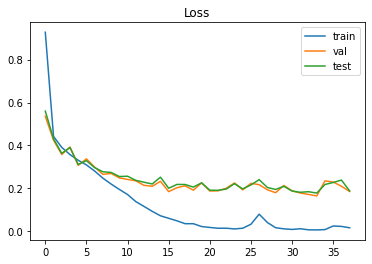

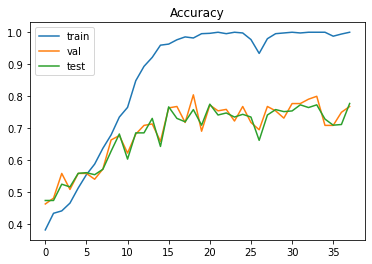

In [46]:
train(100, dev, lr=0.001)